In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import util as utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os.path
import pandas as pd
import scipy
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
precision = 0.005 # m/z precision for raw data
data_per_sec = 2 # spectrum per second
half_time_window = 30 # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 4000 #  everything under this will be annotated false

data_folder = '../data/julijana_datatest/'
mzMl_folder = data_folder + 'mzML/'
mz_files = ["F1.mzML", "F10.mzML", "F11.mzML", "F12.mzML", "F13.mzML", "F14.mzML", "F15.mzML", "F17.mzML", "F18.mzML", "F19.mzML", "F20.mzML", "F21.mzML", "F22.mzML", "F23.mzML", "F24.mzML", "F25.mzML", "F26.mzML", "F27.mzML", "F28.mzML", "F29.mzML", "F30.mzML", "F31.mzML", "F32.mzML", "M1.mzML", "M2.mzML", "M3.mzML", "M4.mzML", "M6.mzML", "M7.mzML", "M8.mzML", "M9.mzML", "M10.mzML", "M11.mzML", "M12.mzML", "M12bis.mzML", "M13.mzML", "M13bis.mzML", "M14.mzML", "M15.mzML", "M18.mzML", "M19.mzML", "M20.mzML", "M21.mzML", "M23.mzML", "M24.mzML", "M25.mzML", "QC_01.mzML", "QC_02.mzML", "QC_03.mzML", "QC_04.mzML"]

raw_peak = data_folder +  'raw_features_lipido_neg.csv'
filtered_peak = data_folder +  'filtered_features_lipido_neg.csv'

pickle_path = './output/pickle_sample/'

In [3]:
peak_model = tf.keras.models.load_model('output/model_peak_1665060139')

In [4]:
class Factory:
    def __init__(self):
        self.features = {}
        self.samples = {}

    def annotate_feature_consensus_dl(self):

        for mz, f in self.features.items():
            for s_name, sample in self.samples.items():
                if mz in sample.annotation_mz:
                    annotation_sample = sample.annotation_mz[mz]
                    if annotation_sample:
                        f['dl_annotation'] = True
                        break

    def get_feature(self):

        return [[mz, ff['rt'] * 60 ] for mz, ff in self.features.items()]

    def get_non_auto_annotated_feature(self):

        return [[mz, ff['rt'] ] for mz, ff in self.features.items() if not ff['dl_annotation']]

    def add_raw_peak(self, file):

        with open(file, newline='') as f:

            reader = csv.reader(f,delimiter=';',)
            next(reader)

            for line in list(reader):
                self.features[float(line[2])] =  {'rt' :float(line[1]), 'manual_annotation': None, 'dl_annotation': None }

    def add_filtered_peak(self, file):

        with open(file, newline='') as f:

            reader = csv.reader(f,delimiter=';',)
            next(reader)

            for line in list(reader):
                self.features[float(line[2].replace(',', '.'))]['manual_annotation'] = True

    def get_filtered_peak(self):
        d = []
        for mz, e in self.features.items():
            if e['manual_annotation'] == True:
               d.append(mz)
        return d

    def get_dl_peak(self):
        d = []
        for mz, e in self.features.items():
            if e['dl_annotation'] == True:
                d.append(mz)
        return d

    def add_samples(self, list_file):

        cptf = 0
        for f in list_file:

            sample_id = f.split('.')[0]
            pick_f = pickle_path + sample_id  + '.npy'

            if not os.path.exists(pick_f):

                list_features = self.get_feature()
                datum = utils.get_data_mz_batch( mzMl_folder + f, list_features)

                X_ = datum[0]
                y_ =  datum[1]
                mz_ = datum[2]
                rt_ =  datum[3]

                with open(pick_f, 'wb') as fi:
                    pass
                    np.save(fi, np.asanyarray([X_, y_, mz_, rt_], dtype=object))

            data = np.load(pick_f, allow_pickle=True)


            s = Sample(sample_id)
            s.data_ = data[0]
            s.annotation_ =  data[1]
            s.mz_ = data[2]
            s.rt_ =  data[3]



            self.samples[sample_id] = s
            print("File {} / {}".format(cptf + 1, len(list_file)))
            print("Features found: {}".format(len(s.data_)))
            cptf += 1

            self.predict(s)

    def predict(self, sample):


        def ret_mats(df):

            xfft = np.hstack([np.vstack(df['fftr']), np.vstack(df['ffti']),
                              np.vstack(df['maxvalstats']),
                          np.vstack(df['minvalstats']),
                          np.vstack(df['maximastats']),
                          np.vstack(df['minimastats']),
                          np.vstack(df['stats'])
                          ])

            xstat = np.hstack([np.vstack(df['maxvalstats']),
                               np.vstack(df['minvalstats']),
                          np.vstack(df['maximastats']),
                          np.vstack(df['minimastats']),
                          np.vstack(df['stats'])
                          ])

            x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
                      np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)

            y = df.y.map(lambda x : float(x))

            return x,xfft,xstat, y


        def smooth(x, window_len=11, window='hanning'):
            """smooth the data using a window with requested size.

            This method is based on the convolution of a scaled window with the signal.
            The signal is prepared by introducing reflected copies of the signal
            (with the window size) in both ends so that transient parts are minimized
            in the begining and end part of the output signal.

            input:
                x: the input signal
                window_len: the dimension of the smoothing window; should be an odd integer
                window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
                    flat window will produce a moving average smoothing.

            output:
                the smoothed signal

            example:

            t=linspace(-2,2,0.1)
            x=sin(t)+randn(len(t))*0.1
            y=smooth(x)

            see also:

            numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
            scipy.signal.lfilter

            TODO: the window parameter could be the window itself if an array instead of a string
            NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
            """

            if window_len < 3:
                return x

            s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
            #print(len(s))
            if window == 'flat':  #moving average
                w = np.ones(window_len, 'd')
            else:
                w = eval('np.' + window + '(window_len)')

            y = np.convolve(w / w.sum(), s, mode='valid')
            return y


        def NormalizeData(data):
            if np.max(data) - np.min(data) == 0.0:
                return data
            return (data - np.min(data)) / (np.max(data) - np.min(data))


        def getStat(data):
            s = [0, 0, 0, 0, 0]  # nbrObs, mean, var,skew, kurtosis

            if len(data) > 0:
                de = scipy.stats.describe(data)
                s = [de[0] / number_ticks, de[2], de[3], de[4], de[5]]

            return np.nan_to_num(np.array(s))


        def filter_threshold(values):
            if max(values) >= intensity_treshold:
                return True
            return False



        df = pd.DataFrame(sample.data_)
        df['y']= sample.annotation_
        df['mz']= sample.mz_
        df['rt']= sample.rt_
        df = pd.DataFrame.rename(df, columns = {0:'x'})

        df = df[df['x'].map(lambda  x: filter_threshold(x))]

        df['norm'] = df['x'].apply(lambda x: NormalizeData(x) )
        df['y'] = df['y'].apply(lambda x: 1 if x == True else 0)


        df['smooth'] = df['norm'].apply(lambda x: smooth(x) )
        df['smooth'] = df['smooth'].apply(lambda x: x[5:-5] )

        df['grad1'] = df['smooth'].apply(lambda x: np.gradient(x) )
        df['grad2'] = df['grad1'].apply(lambda x: np.gradient(x) )


        # Maxima & Minima
        df['maxima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(x, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )
        df['minima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(-x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )

        df['maxval'] =  df[['smooth', 'maxima']].apply(lambda x: [x.smooth[i] for i in x.maxima], axis=1)
        df['minval'] =  df[['smooth', 'minima']].apply(lambda x: [x.smooth[i] for i in x.minima], axis=1)

        df['maxvalnorm'] =  df['maxval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )
        df['minvalnorm'] =  df['minval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )

        # Stats
        df['maxvalstats'] =  df['maxvalnorm'].apply(lambda x: getStat(x) )
        df['minvalstats'] =  df['minvalnorm'].apply(lambda x: getStat(x) )

        df['maximastats'] =  df['maxima'].apply(lambda x: getStat(x) )
        df['minimastats'] =  df['minima'].apply(lambda x: getStat(x) )

        df['stats'] =  df['smooth'].apply(lambda x: getStat(x) )

        df['fft'] = df['x'].apply(lambda x: np.fft.fft(x) )
        df['fftr'] = df['fft'].apply(lambda x: np.real(x) )
        df['ffti'] = df['fft'].apply(lambda x: np.real(np.imag(x)) )


        mats = ret_mats(df)

        pre_rawi = peak_model.predict([mats[0], mats[1], mats[2]])

        cpt = 0

        for p in pre_rawi[1]:

            if (float(p[0])) > 0.5:

                sample.annotation_mz[df['mz'].iloc[cpt]] = True

            else:
                sample.annotation_mz[df['mz'].iloc[cpt]] = False


            cpt +=1


        '''

        for p in pre_rawi:

            df_key = list(mats[3].keys())[cpt]

            #if p[1] > 0.5 and df['treshold_satisfied'][df_key] == 1 :
            if p[1] > 0.5:
                sample.annotation_mz[df['mz'][df_key]] = True

                dfdf = df['x'][df_key]
                if max(dfdf) > intensity_treshold:
                    plt.title( str(df['mz'][df_key]) )
                    plt.plot(dfdf , color = 'green')
                    plt.show()
            else:
                sample.annotation_mz[df['mz'][df_key]] = False

                dfdf = df['x'][df_key]
                if max(dfdf) > intensity_treshold:
                    plt.title( str(df['mz'][df_key]) )
                    plt.plot(dfdf , color = 'red')
                    plt.show()


            cpt +=1

        '''

    def plot(self, mz):

        data_F = []
        data_M = []
        data_QC = []

        for sample_name, sample in self.samples.items():
            idx = np.where(sample.mz_ == float(mz))[0]
            if len(idx)>0:
                if sample_name[0] == 'F':
                    data_F.append(sample.data_[idx[0]])
                elif sample_name[0] == 'M':
                    data_M.append(sample.data_[idx[0]])
                elif sample_name[0] == 'Q':
                    data_QC.append(sample.data_[idx[0]])

        # Initialise the subplot function using number of rows and columns
        figure, axis = plt.subplots(2, 2)


        for fdata in data_F:
            axis[0, 0].plot(fdata)
        axis[0, 0].set_title("F" + str(mz) )

        for mdata in data_M:
            axis[0, 1].plot(mdata)
        axis[0, 1].set_title("M" + str(sample.rt_[idx[0]]))

        for qdata in data_QC:
            axis[1, 0].plot(qdata)
        axis[1, 0].set_title("QC")


        # Combine all the operations and display
        plt.show()


class Sample:
    def __init__(self, id):
        self.id = id
        self.data_ = []
        self.annotation_ = []
        self.mz_ = []
        self.rt_ = []
        self.annotation_mz = {}


In [7]:
import random

data = Factory()
data.add_raw_peak(raw_peak)
data.add_filtered_peak(filtered_peak)
data.add_samples(random.choices(mz_files, k=10))
data.annotate_feature_consensus_dl()


File 1 / 10
Features found: 33196


2022-11-02 15:12:37.944853: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


341/341 [==============================] - 12s 34ms/step
File 2 / 10
Features found: 33196
354/354 [==============================] - 12s 34ms/step
File 3 / 10
Features found: 33196
356/356 [==============================] - 12s 34ms/step
File 4 / 10
Features found: 33196
349/349 [==============================] - 11s 33ms/step
File 5 / 10
Features found: 33196
362/362 [==============================] - 12s 33ms/step
File 6 / 10
Features found: 33196
336/336 [==============================] - 11s 32ms/step
File 7 / 10
Features found: 33196
363/363 [==============================] - 12s 33ms/step
File 8 / 10
Features found: 33196
362/362 [==============================] - 12s 33ms/step
File 9 / 10
Features found: 33196
336/336 [==============================] - 11s 32ms/step
File 10 / 10
Features found: 33196
340/340 [==============================] - 11s 32ms/step


In [8]:
me = set(data.get_dl_peak())
her = set(data.get_filtered_peak())

print(len(me & her))
print(len(me - her))
print(len( her - me))


266
5808
87


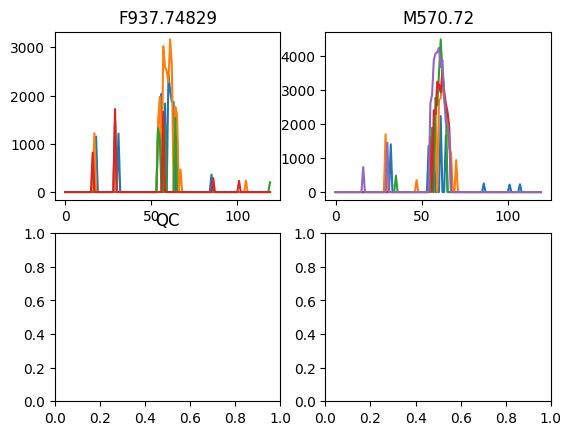

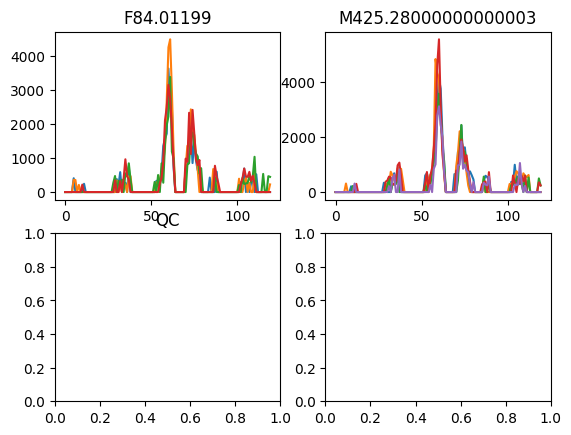

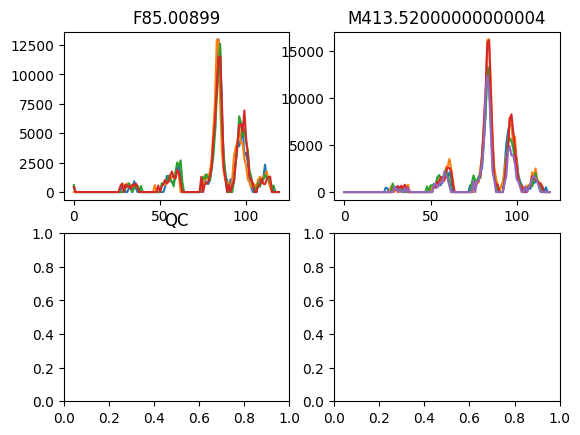

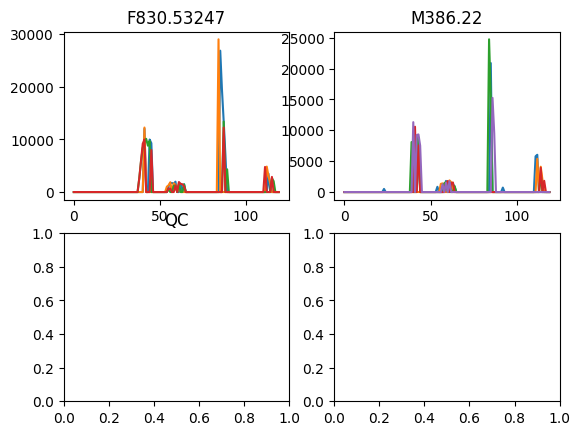

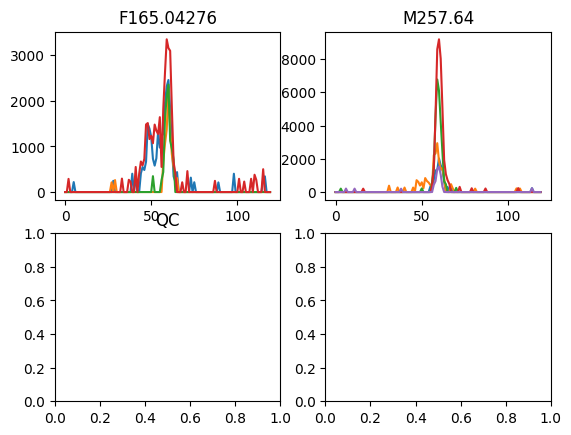

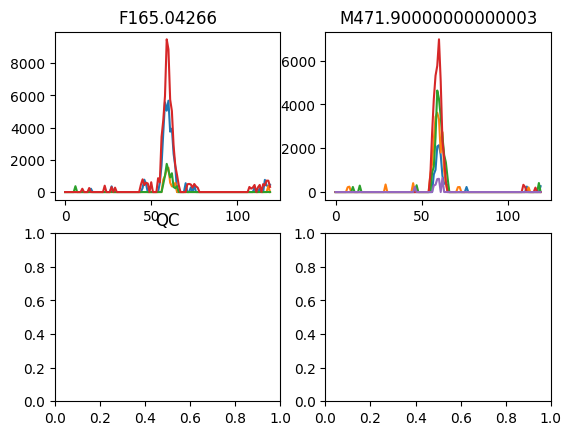

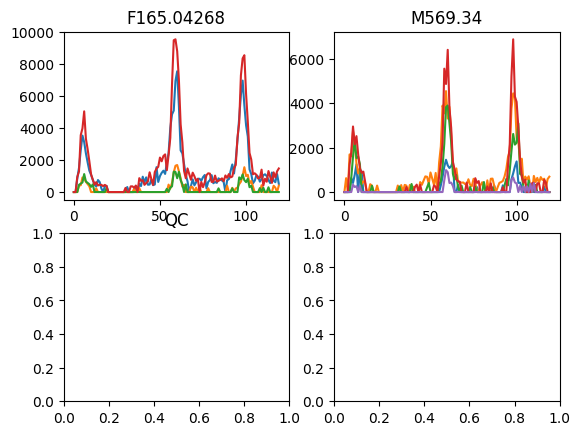

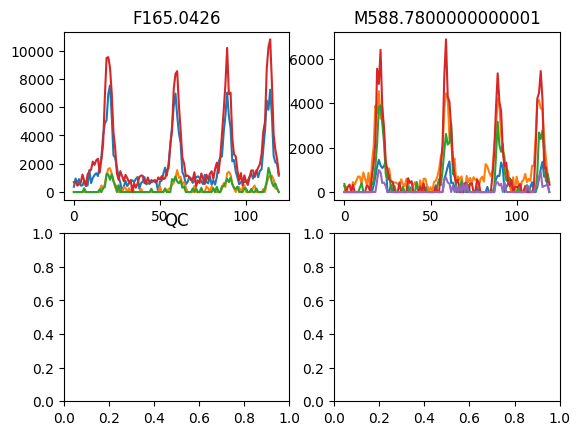

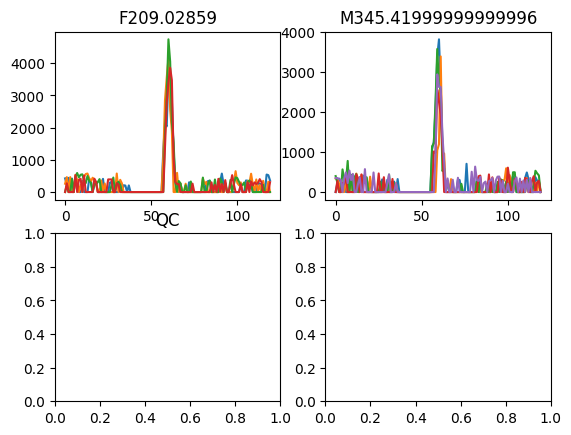

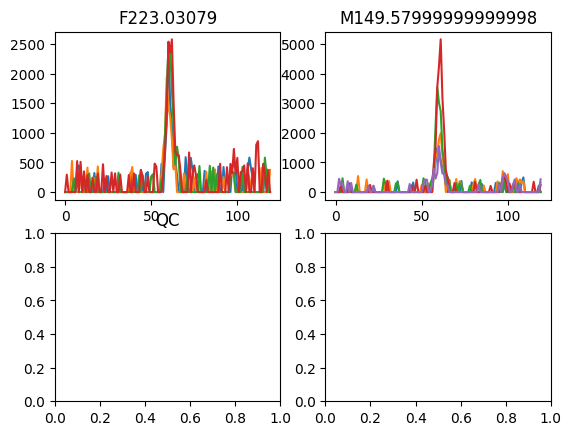

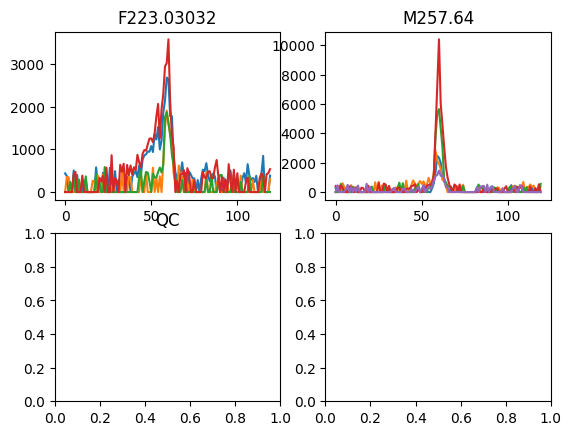

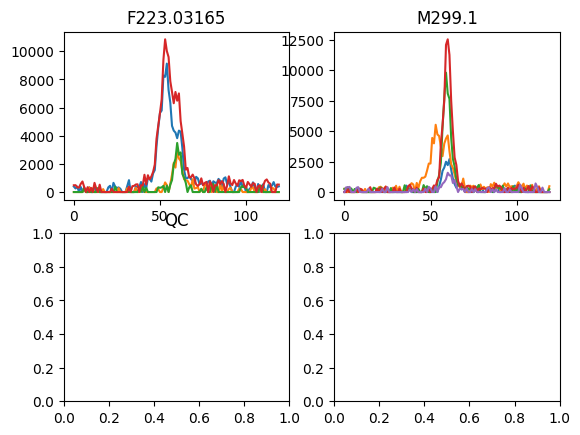

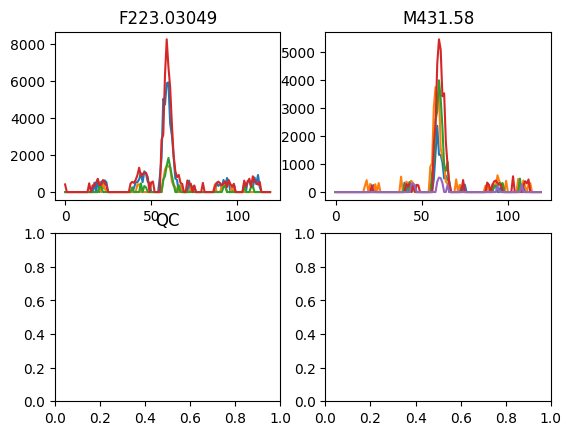

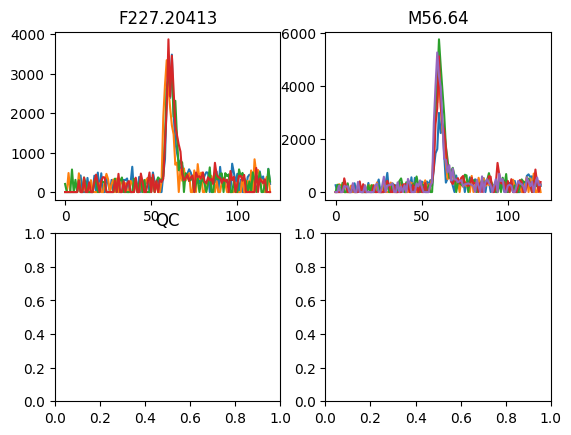

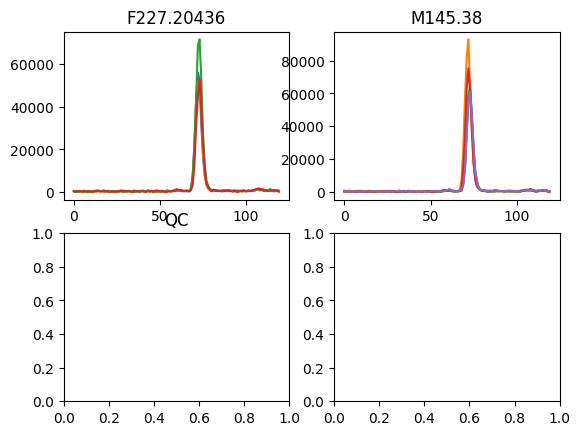

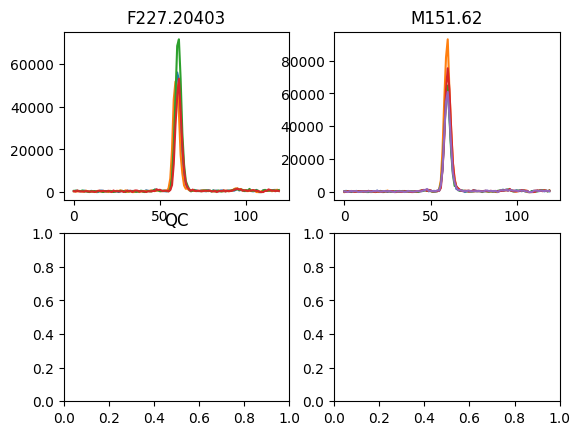

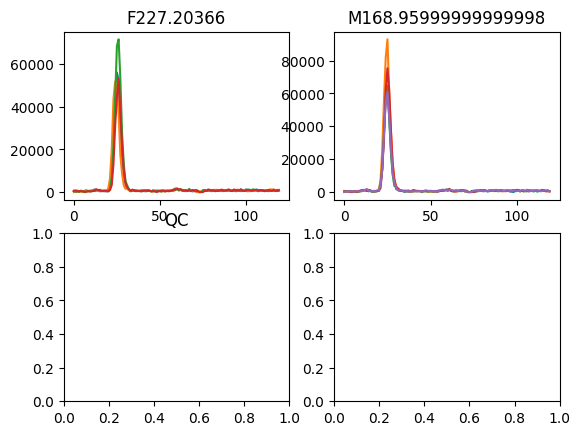

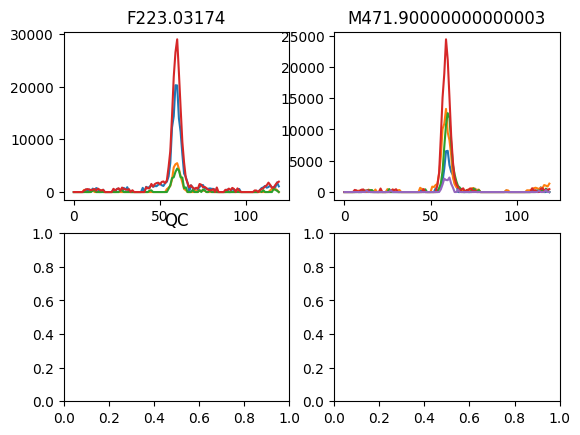

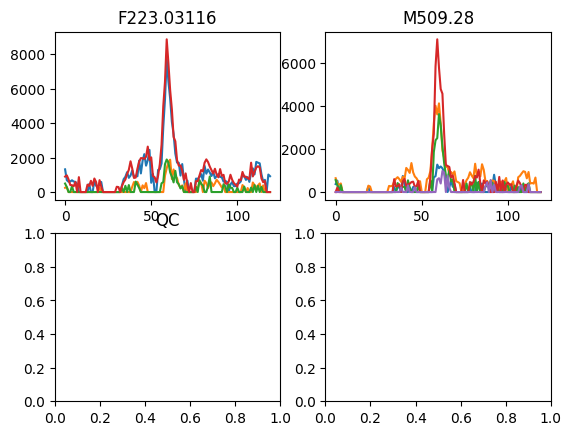

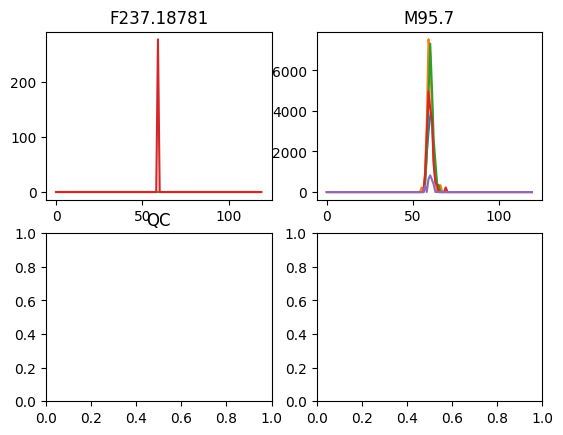

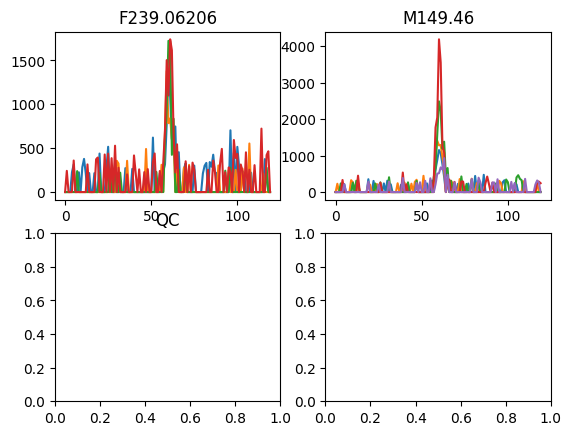

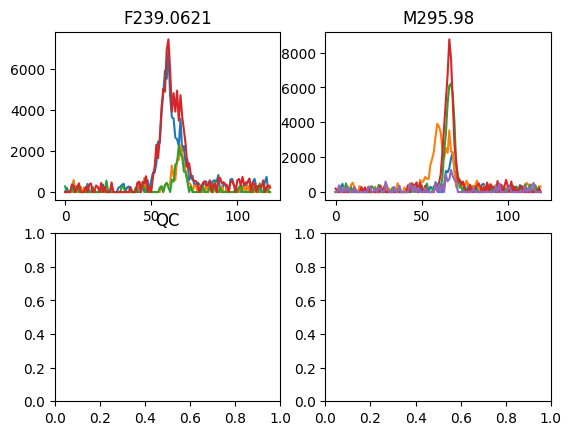

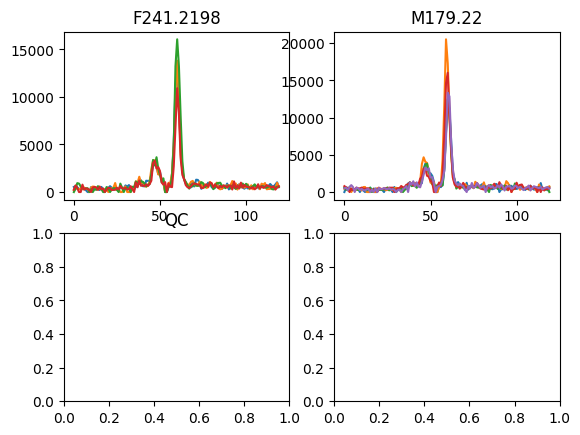

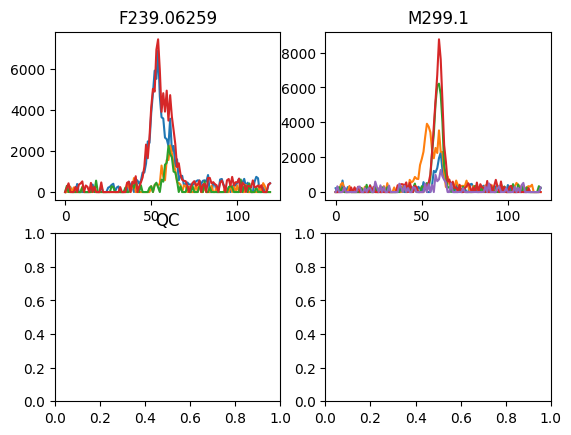

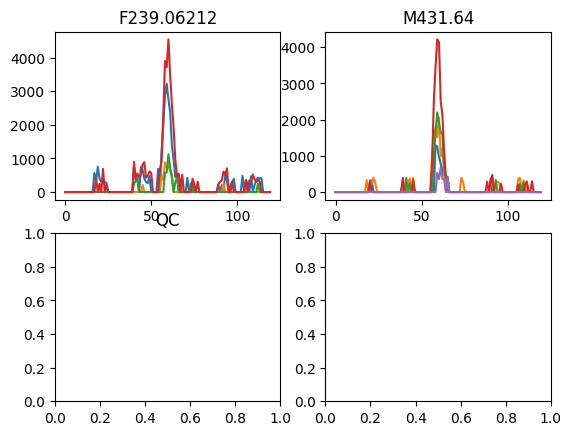

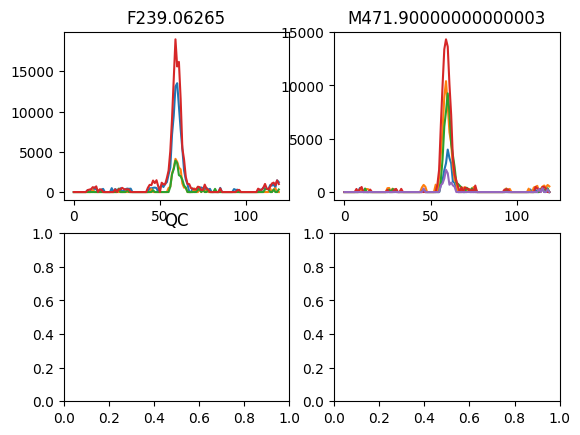

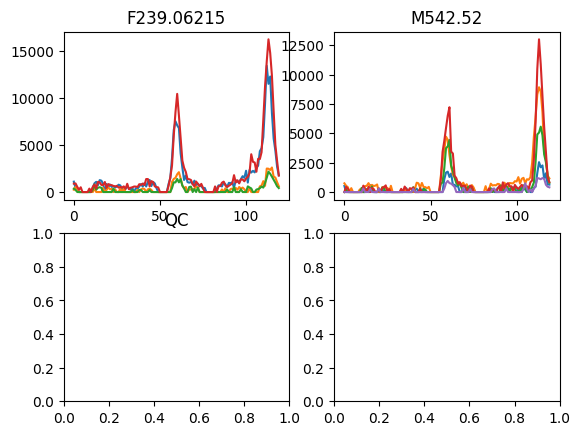

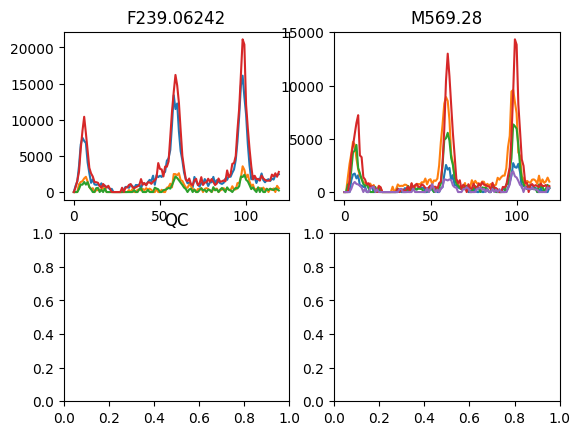

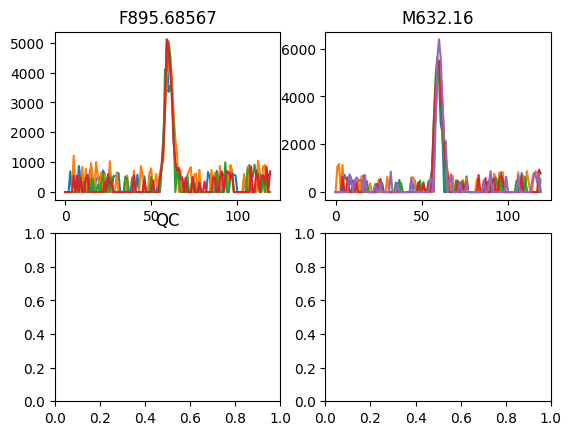

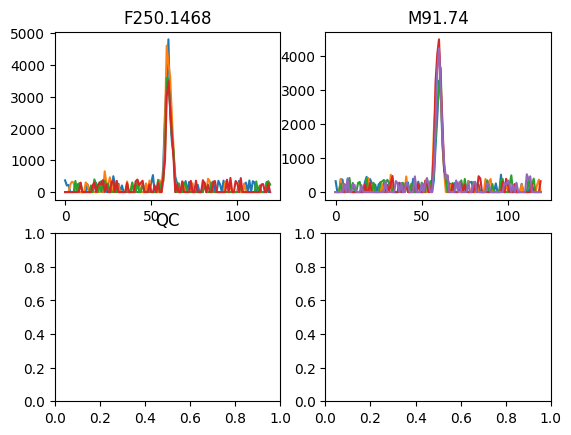

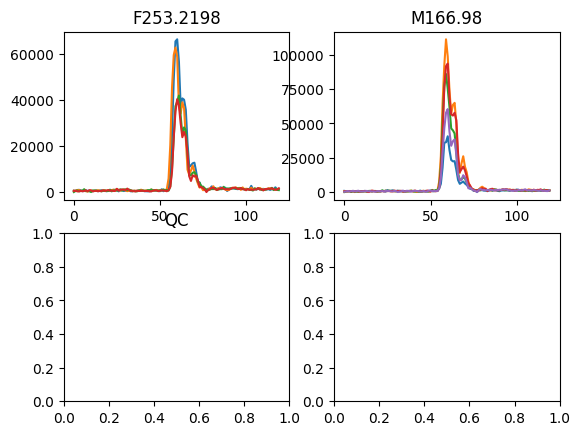

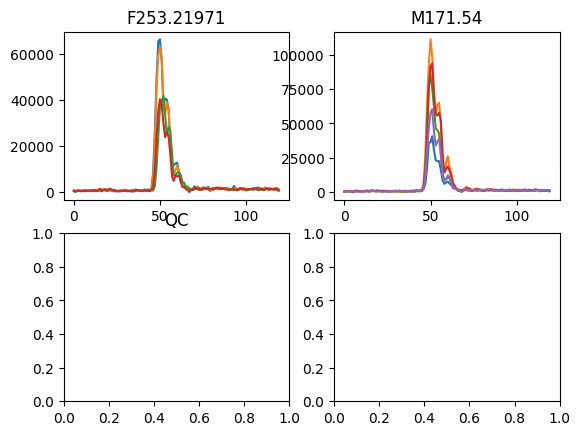

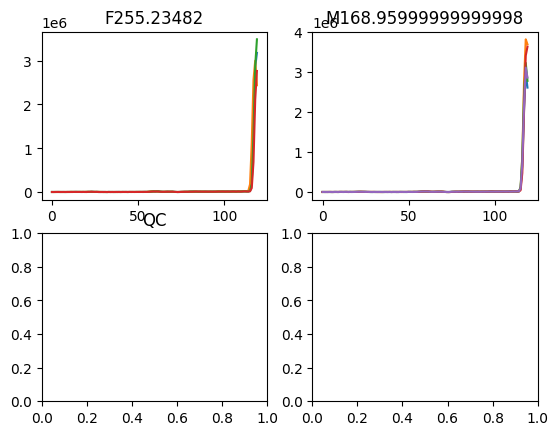

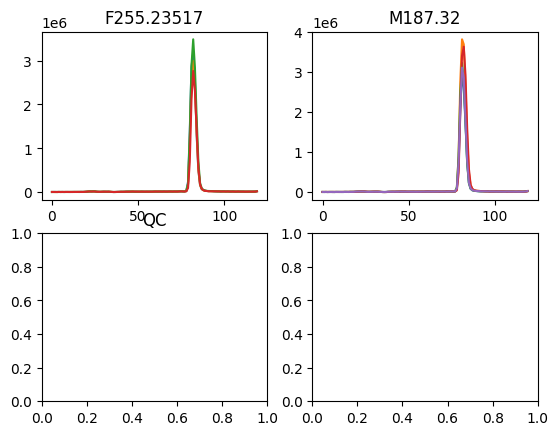

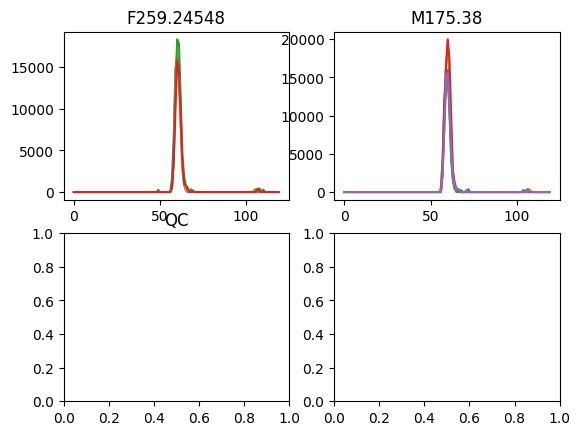

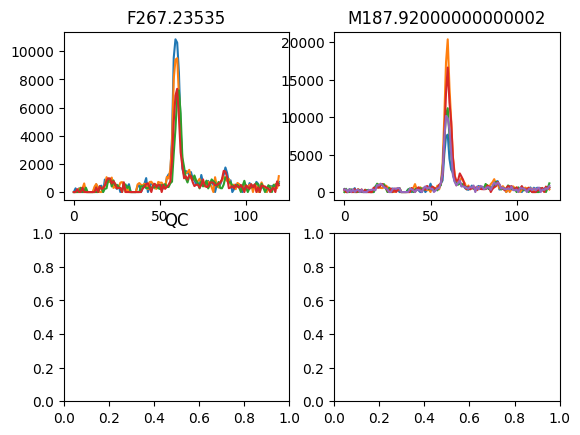

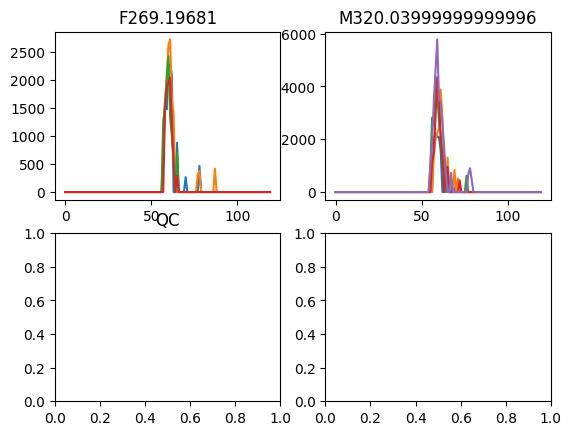

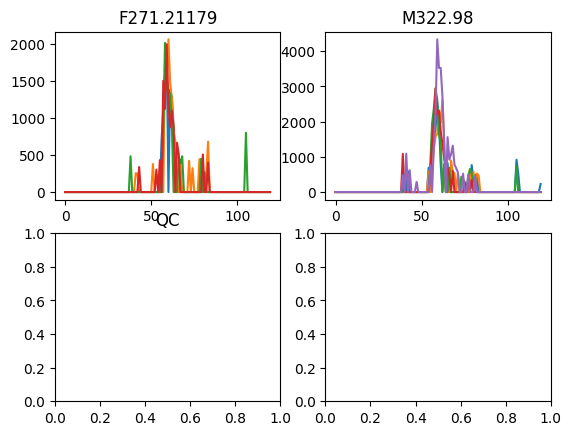

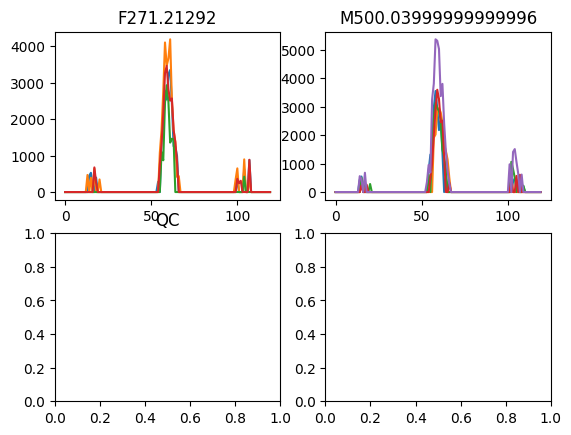

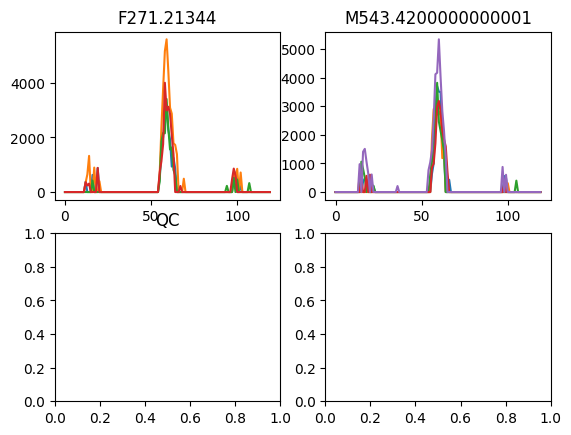

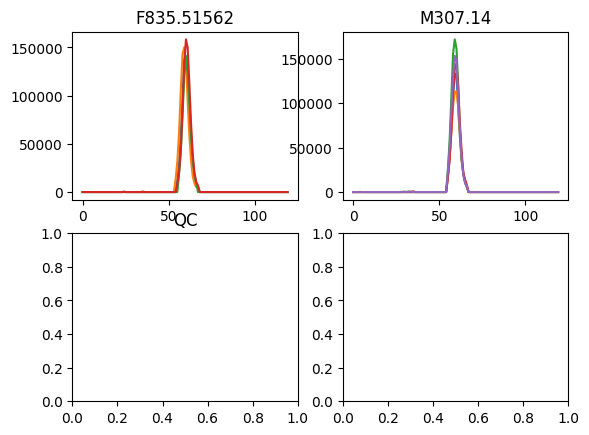

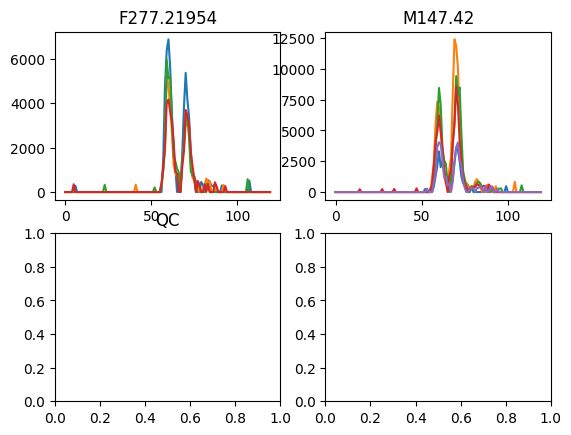

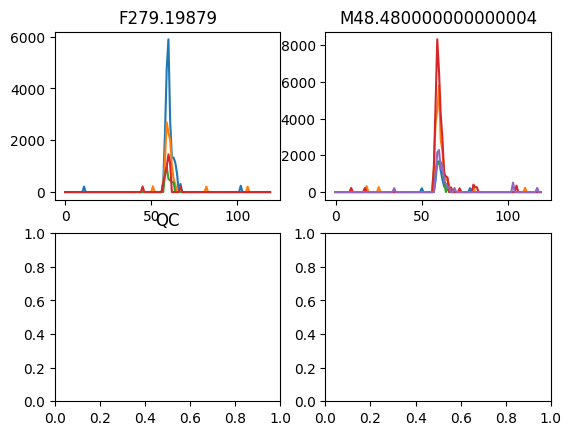

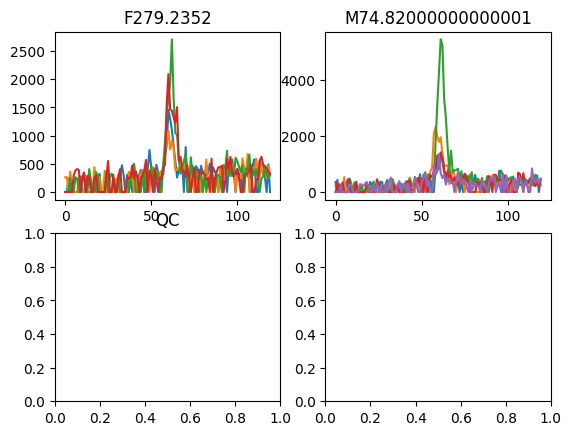

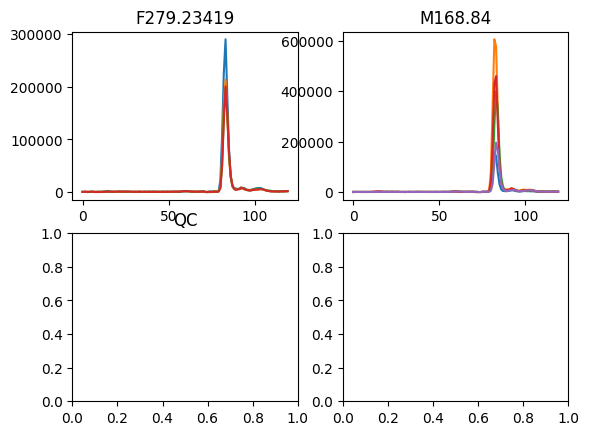

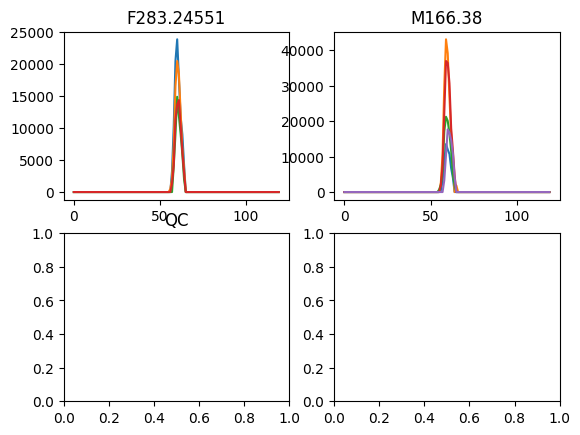

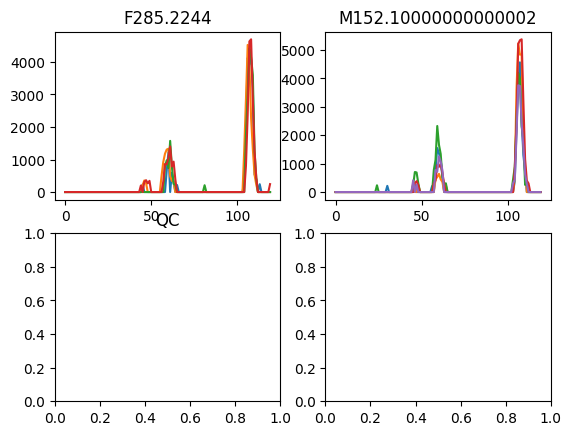

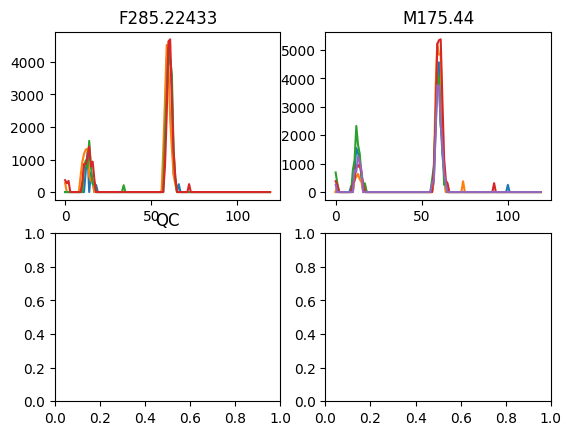

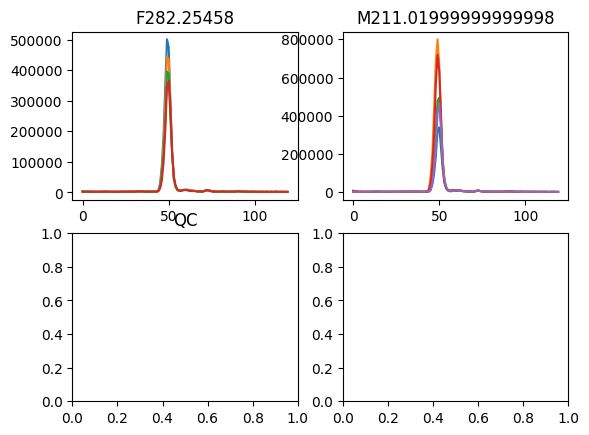

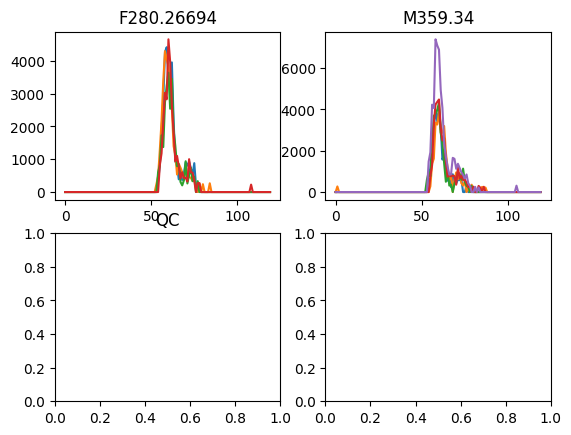

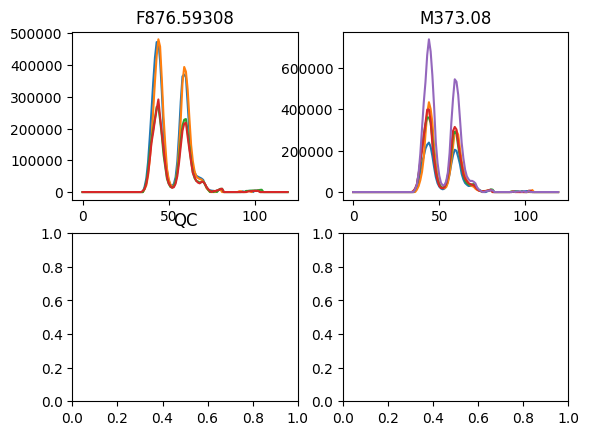

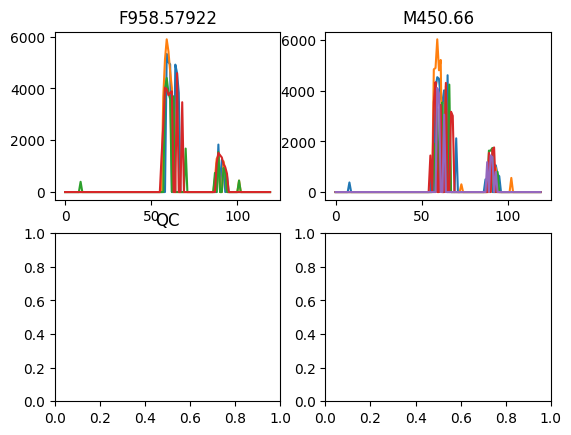

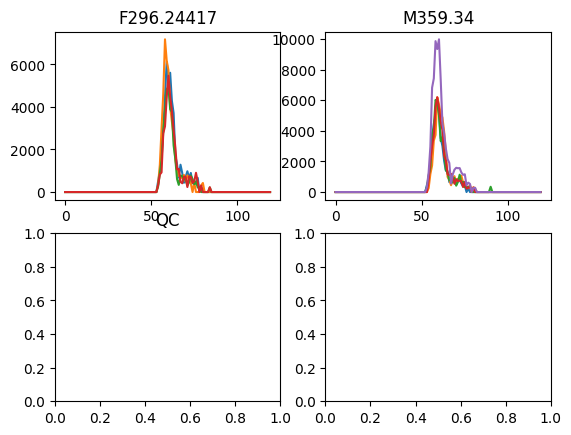

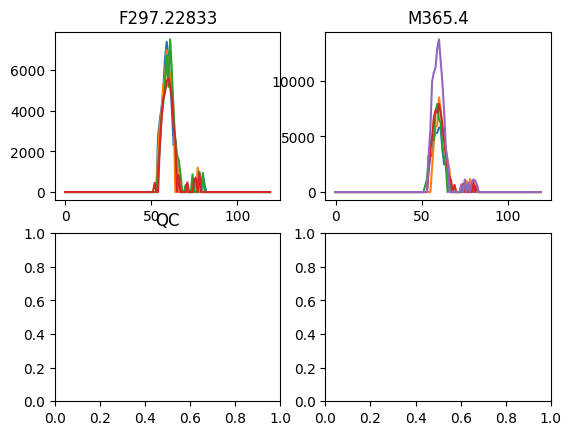

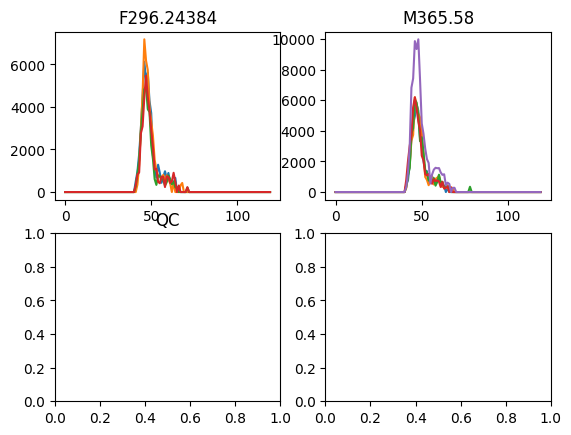

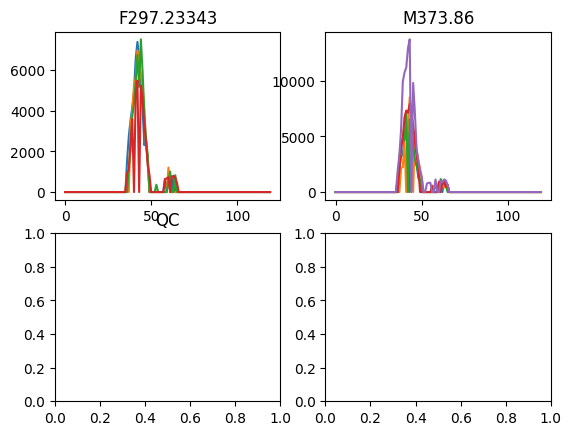

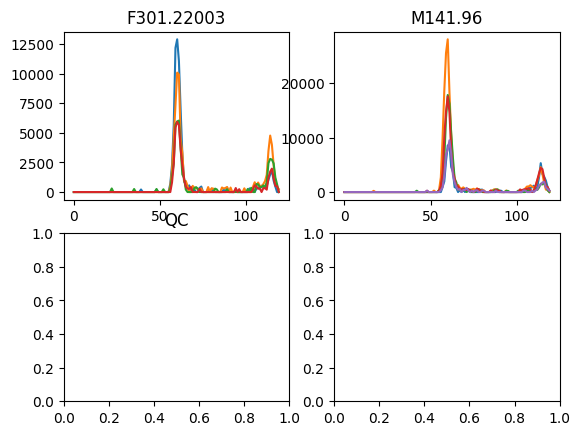

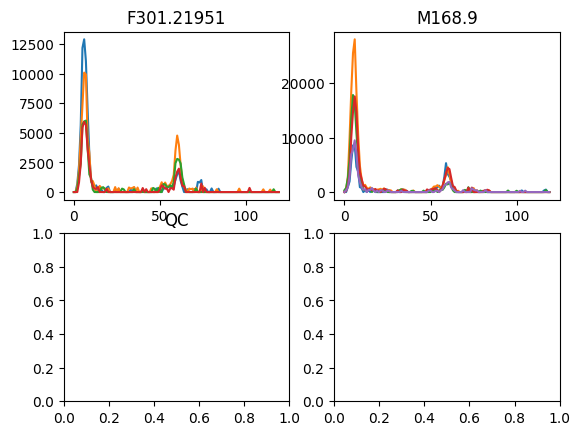

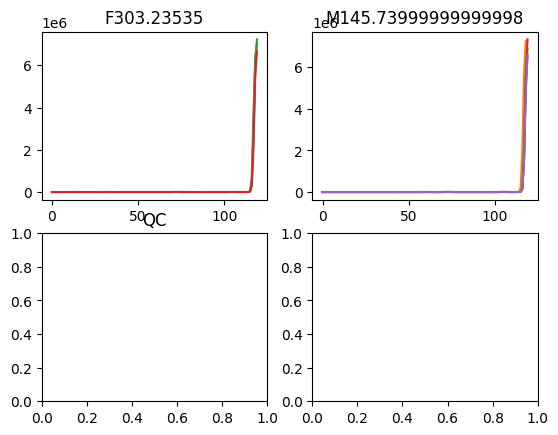

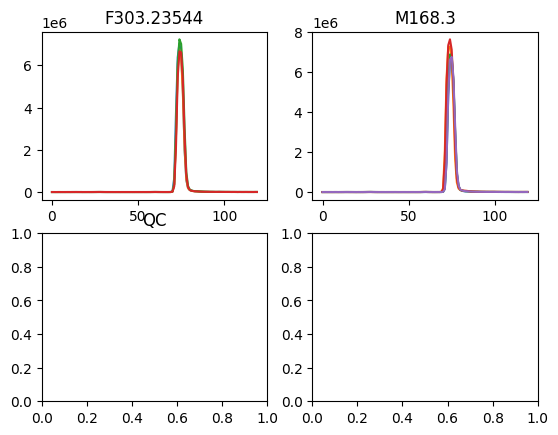

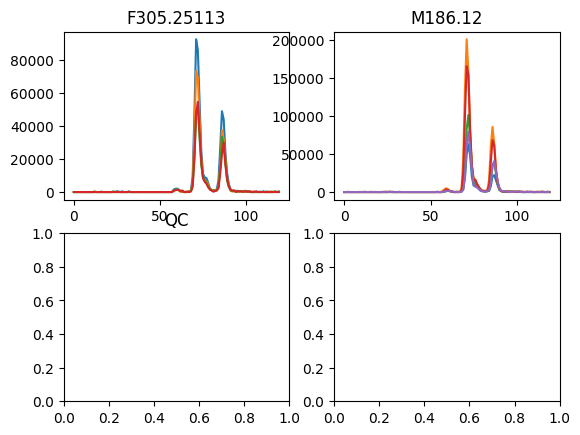

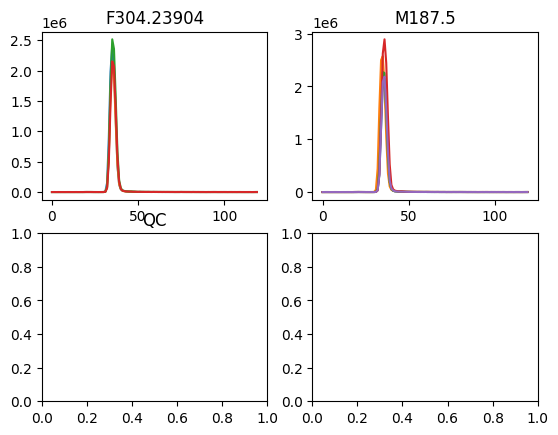

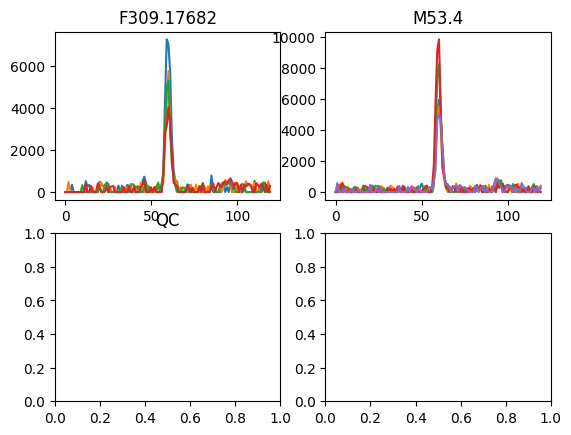

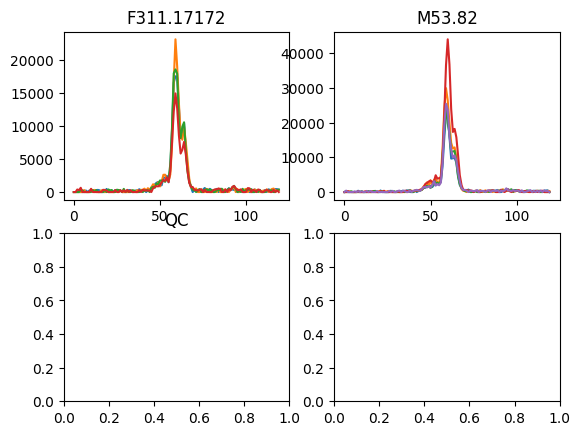

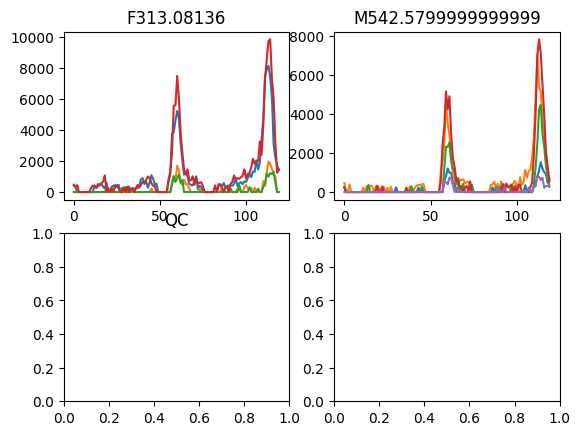

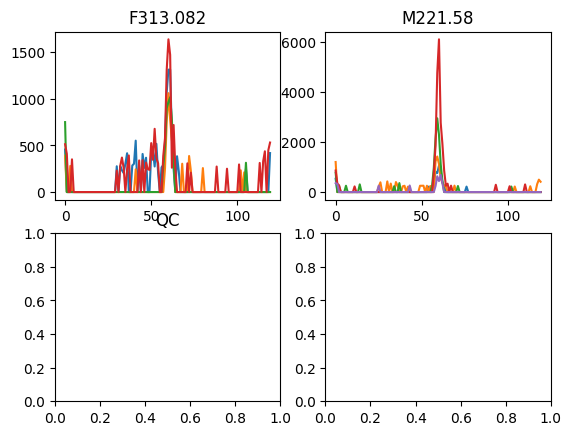

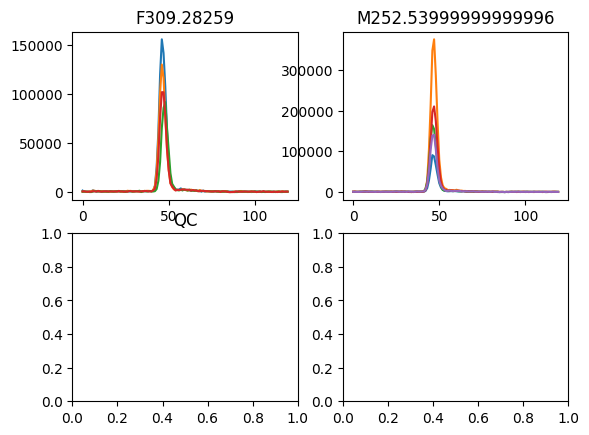

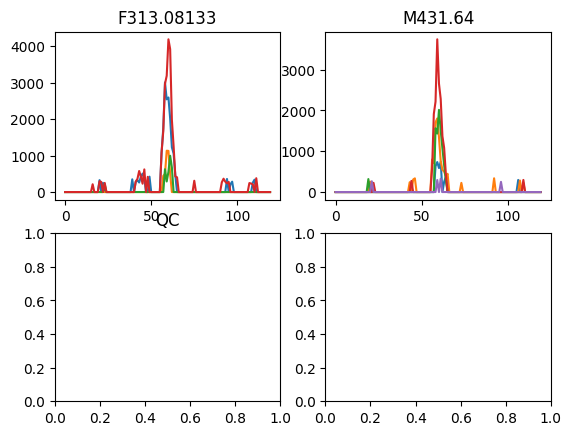

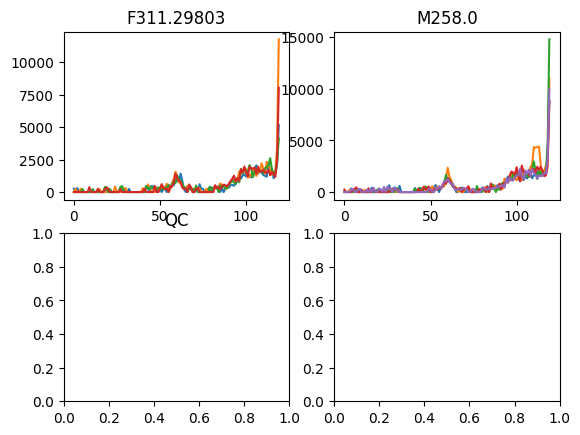

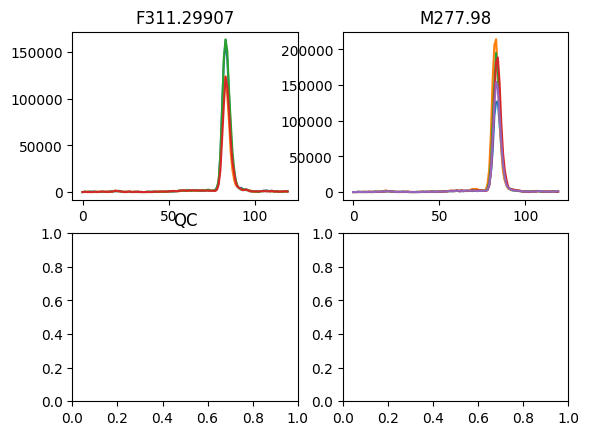

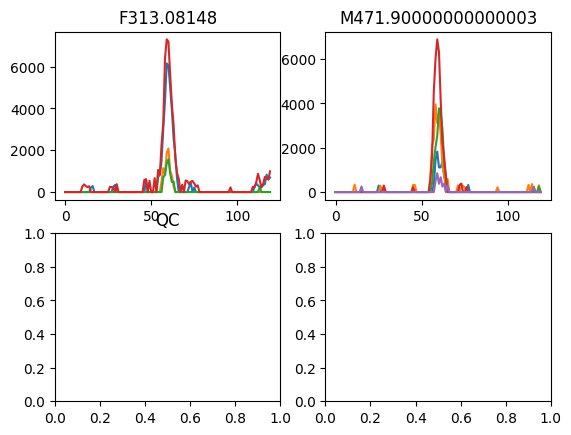

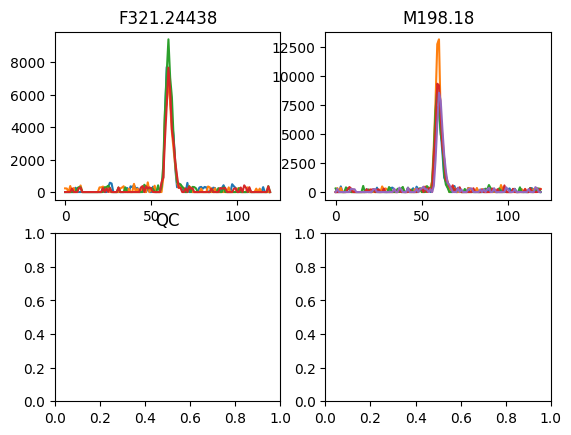

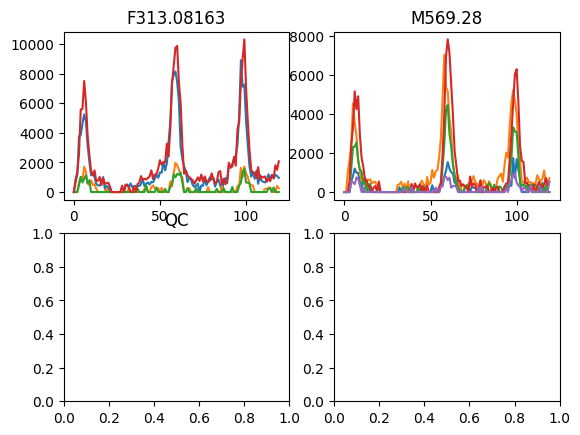

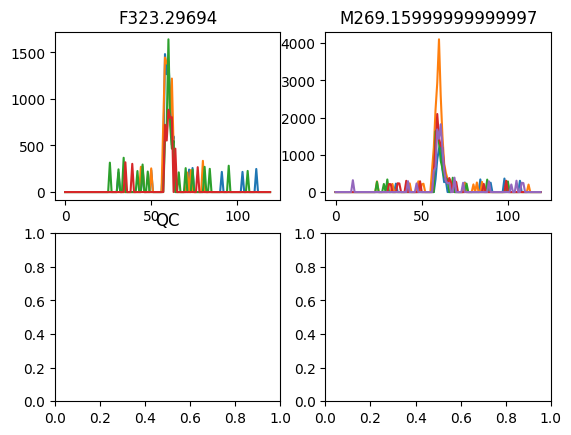

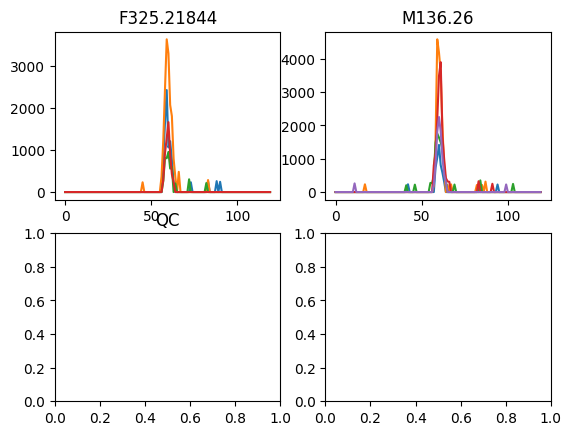

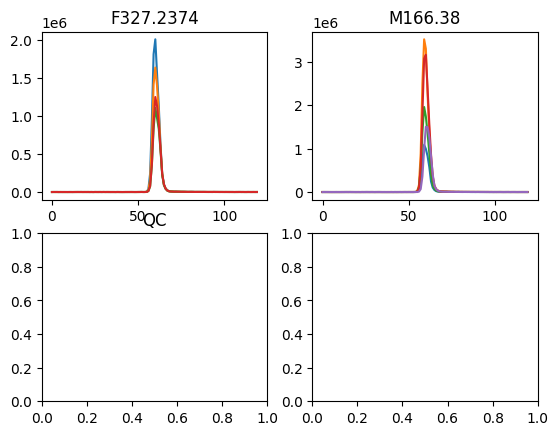

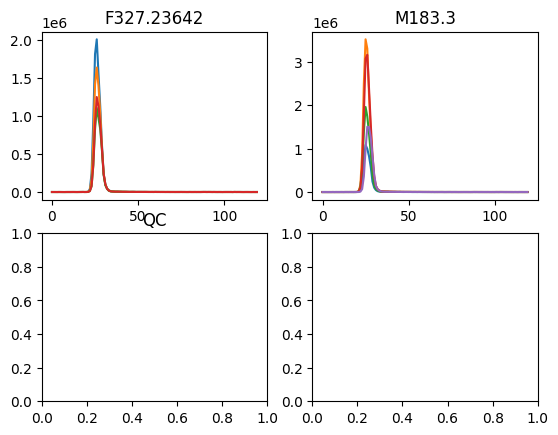

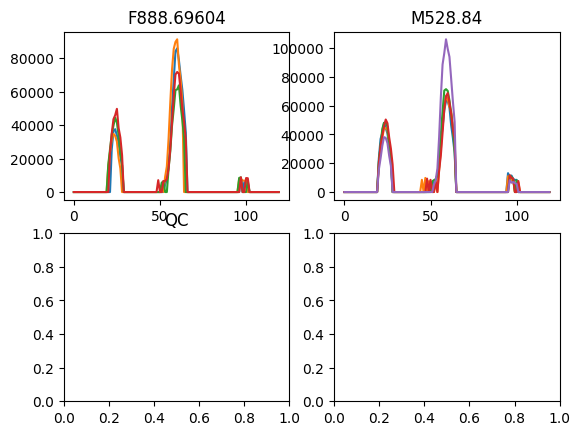

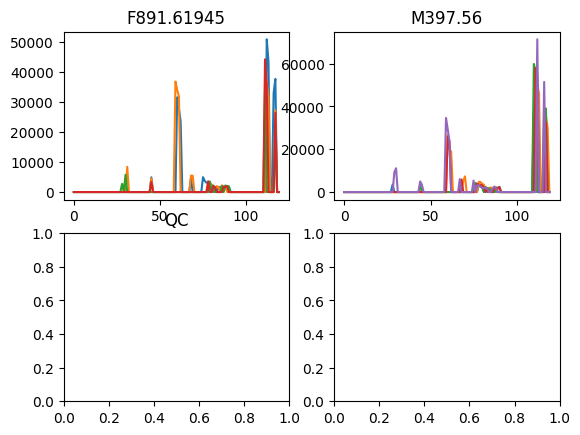

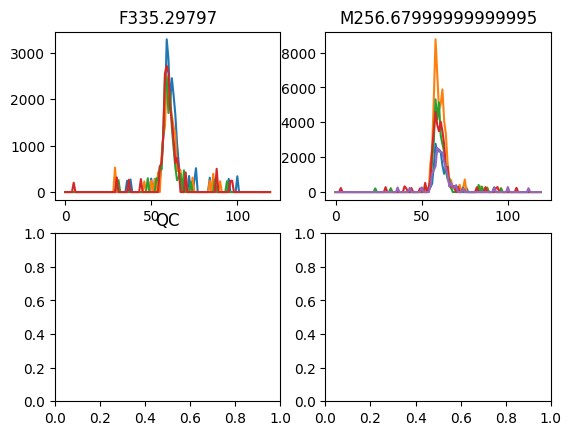

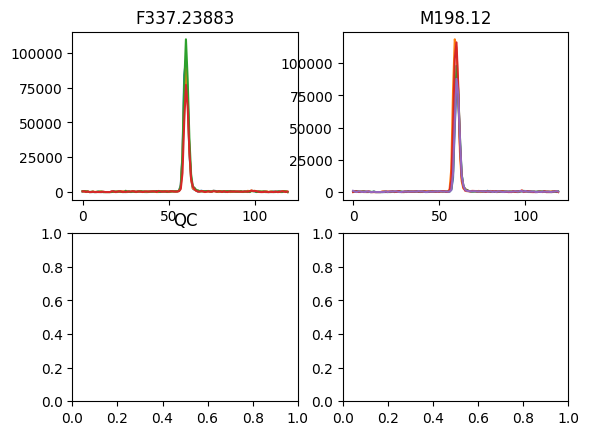

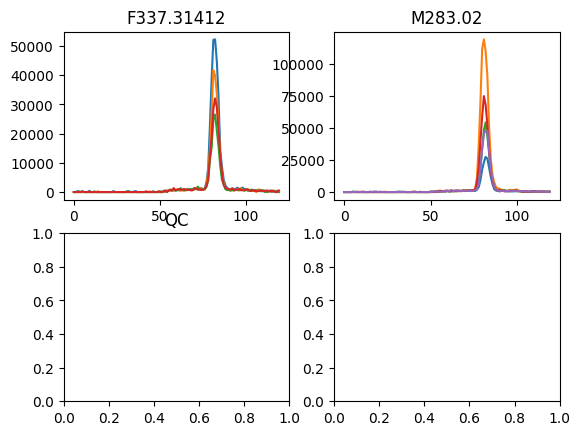

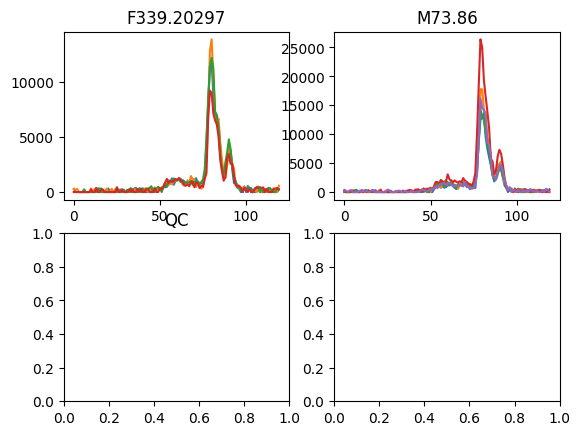

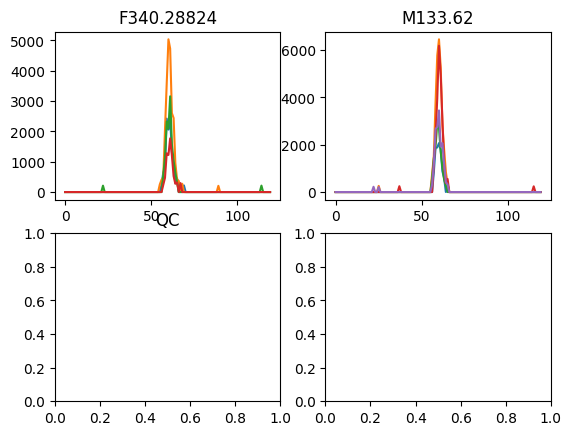

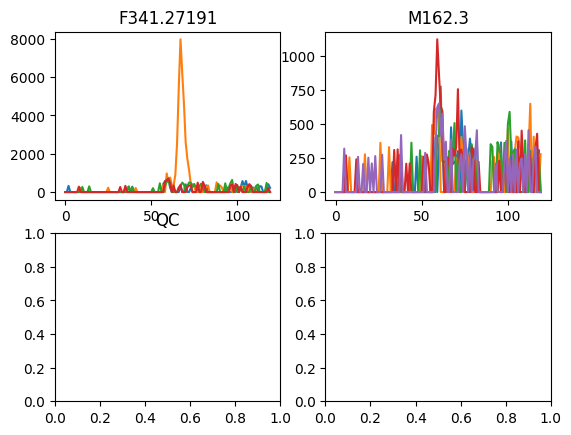

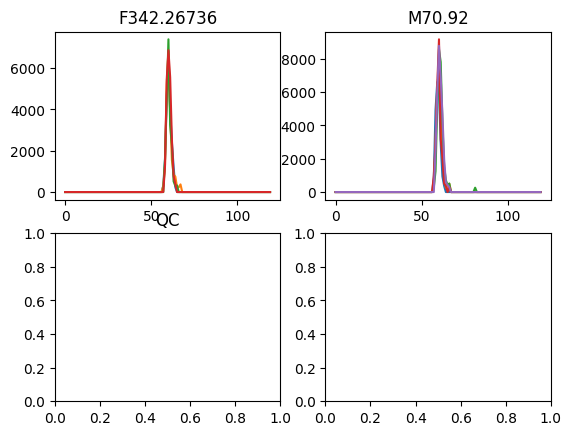

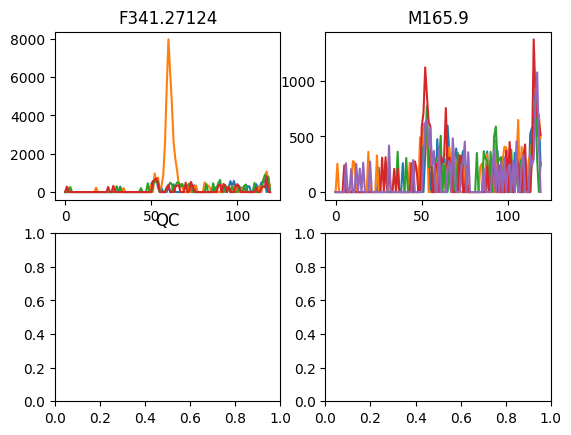

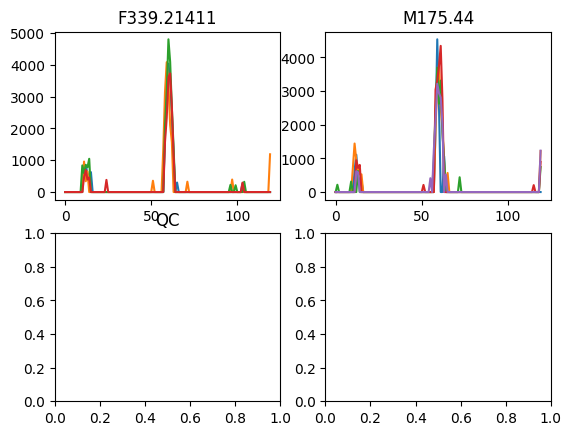

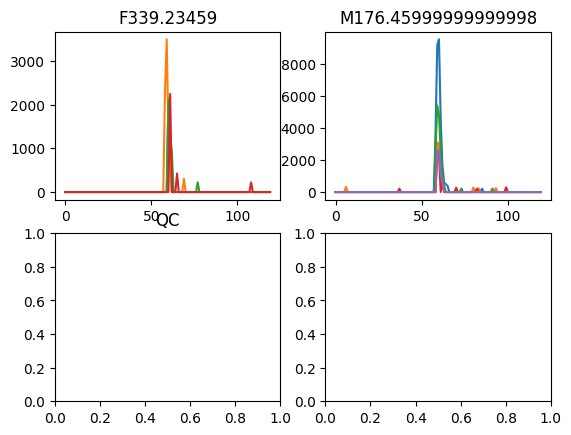

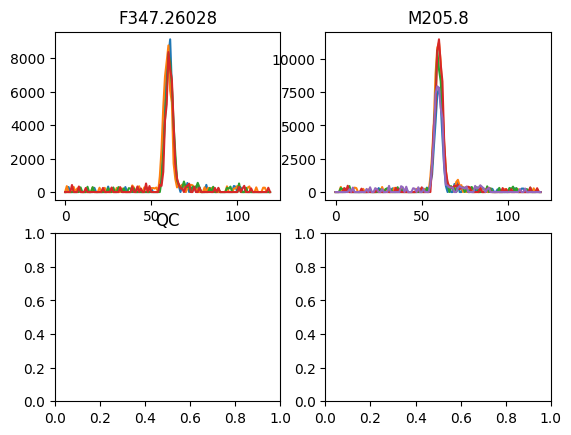

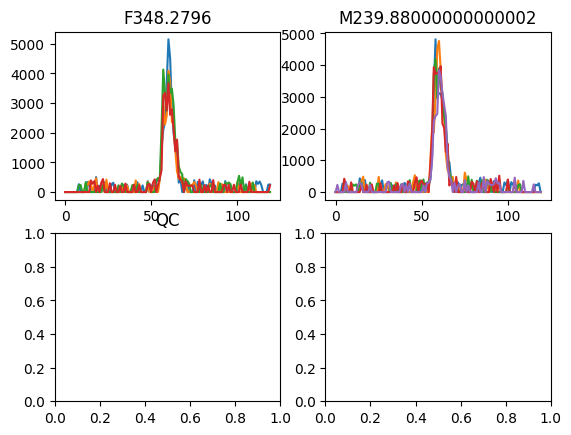

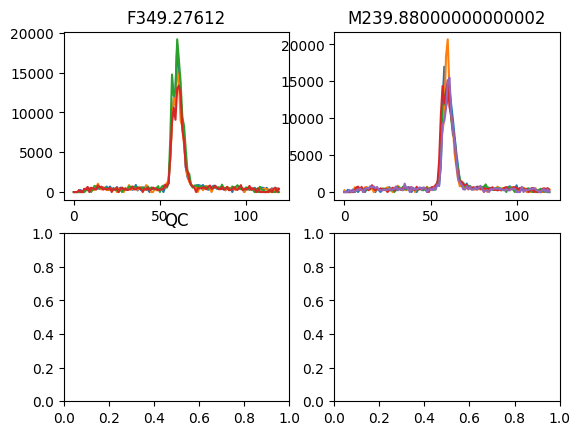

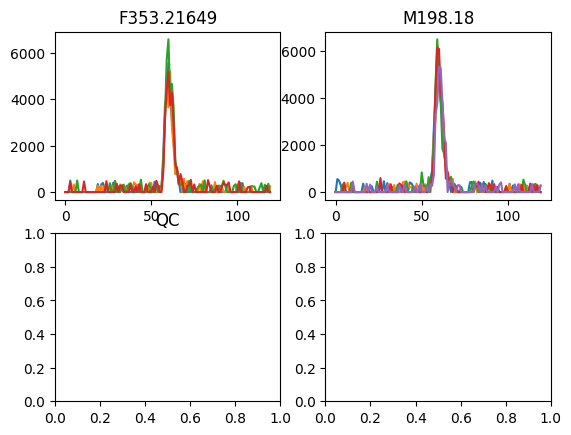

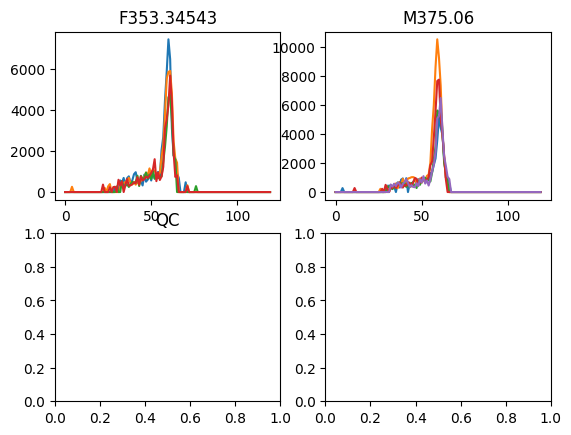

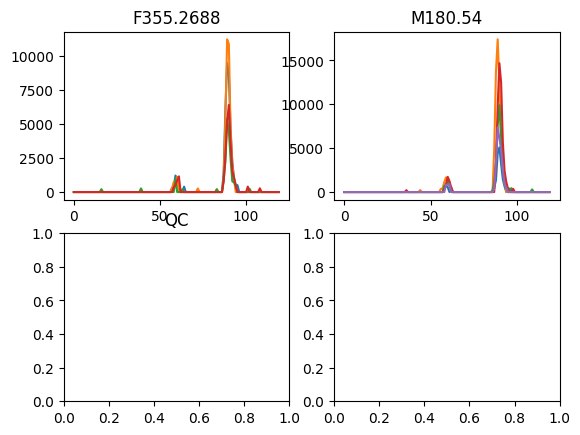

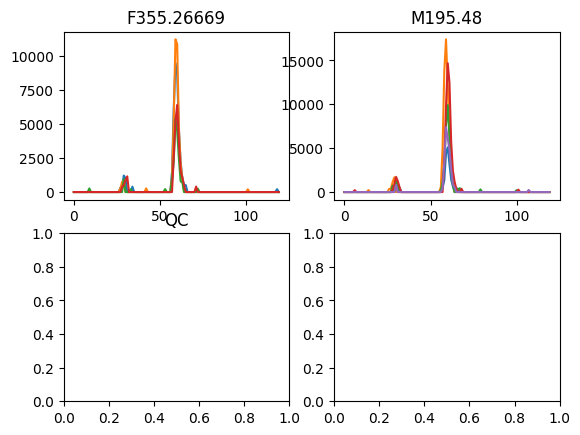

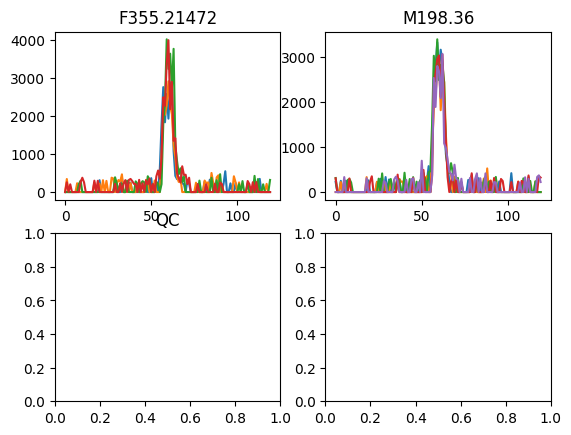

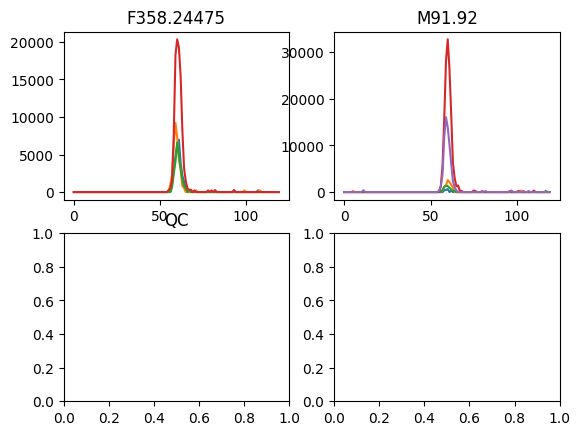

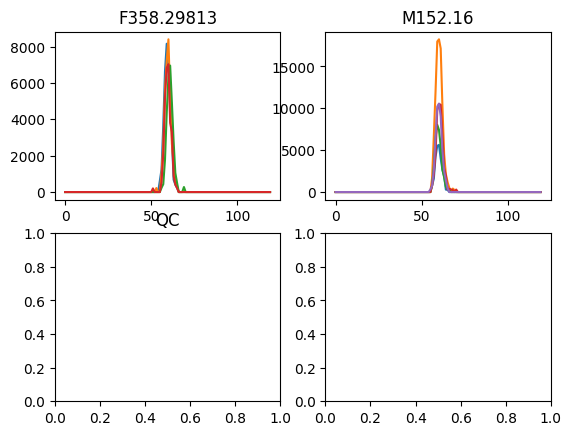

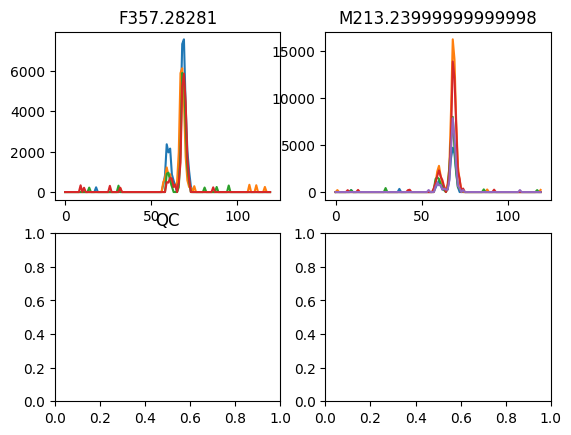

In [9]:
for e in list(me - her)[:100]:
    data.plot(e)

In [ ]:
222
2722
131

266
6264
87